In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/amazon-walmart/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-walmart')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in data.keys():
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-walmart/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-walmart/glove-300.matrix.npy',
                        text_columns = ['brand', 'groupname', 'title', 'shelfdescr',
                                        'shortdescr', 'longdescr'],
                        numeric_columns = ['price', 'shipweight', 'length', 'width', 'height'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['inverse_l1', 'cosine'],
                        text_compositions=['average', 'idf', 'bi_lstm'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True,
                        dropout=0.75,
                        batch_norm=True,
                        lstm_args=dict(units=20, dropout=0.25, recurrent_dropout=0.25),
                        shared_lstm=True,
                        embedding_trainable=True)

Number of inputs to dense layer: 205


# Crash recovery 

In [4]:
model.load_weights('../data/models/amazon-walmart-all-full')
df_hist = pd.read_csv('../data/histories/amazon-walmart-all-full.csv')

histories['acc'] = list(df_hist['acc'].values)
histories['val_acc'] = list(df_hist['val_acc'].values)
histories['loss'] = list(df_hist['loss'].values)
histories['val_loss'] = list(df_hist['val_loss'].values)

# Train model 

In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=512,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 93243 samples, validate on 11656 samples
Epoch 1/1
93243/93243 [==============================] - 876s 9ms/step - loss: 0.0119 - acc: 0.9974 - val_loss: 0.0295 - val_acc: 0.9961


# Learning curves

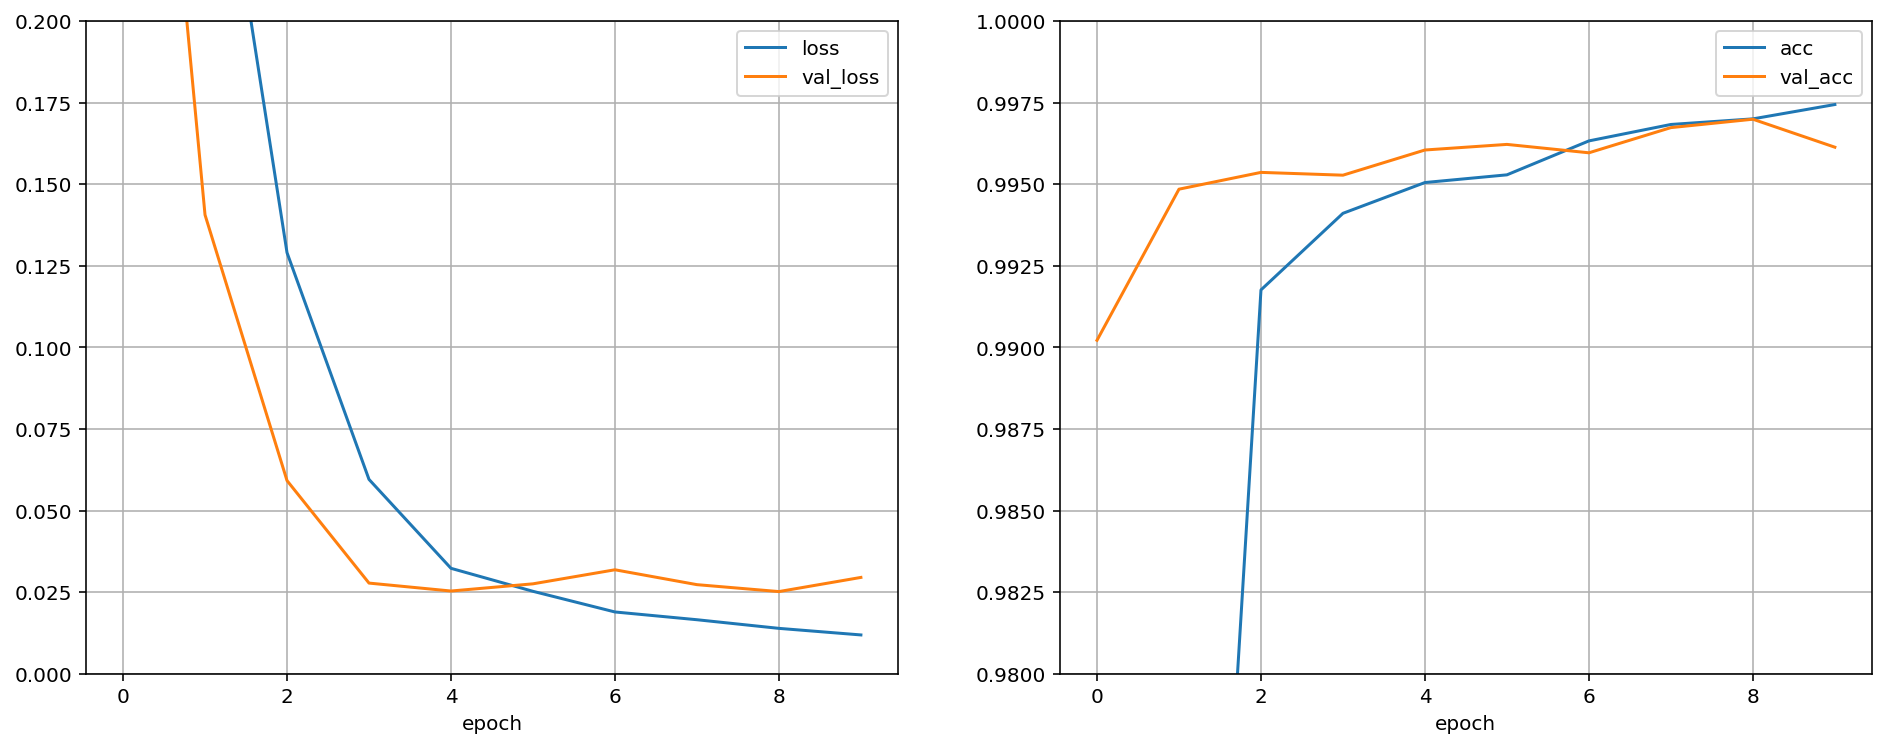

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set(ylim = (0, 0.2))
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set(ylim = (0.98, 1))

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [41]:
y_val_pred = model.predict(X_val, batch_size=2048)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11525
          1       0.82      0.94      0.88       131

avg / total       1.00      1.00      1.00     11656

[[11498    27]
 [    8   123]]


In [42]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & (y_val_pred >= 0.5)
columns = ['brand', 'groupname', 'title', 'shelfdescr',
           'shortdescr', 'longdescr']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(10)

,id1,brand,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,...,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,width,height
9734,12443,Rocstor,NaN,1.5TB ROCPRO 850 7200 Rpm 32MB FW800 USB ESATA,360.00,FW800 USB ESATA INT PWR SUP,NaN,1.5TB ROCPORT 850 7200 RPM 32MB FW800 USB ESATA INT PWR SUP,0.0,11.0,...,Hard Drives,Rocstor G222R2-01 ROCPRO 850 External Hard Drive,159.98,1.5TB storage capacity External form factor FireWire and USB host interface,The Rocstor G222R2-01 ROCPRO 850 External Hard Drive delivers extraordinary performance and reliability for both Mac and PC users. Specifically designed for demanding audio video professionals the new ROCPRO 850 contains a fast SATA high capacity 3.5 drive mechanism in a stylish and unique aluminum case that can be stacked or mounted VERTICALLY. With its built-in power supply fan-less and quite operation the ROCPRO 850 can be easily moved from one desktop environment to another using the provided carrying case.,1.5TB storage capacity External form factor FireWire and USB host interface Plug and play,4.95,8.66,5.79,1.61
7254,1275,Wintec,Computer Accessories,Wintec Filemate 4 GB Class 4 Secure Digital SDHC Card,7.99,Compatible With High-Capacity HC Devices On-Board Error Correction Low Power Consumption And Smart Power Management High Speed Serial Interface With Random Access Extended Memory Lifetime With Thousands Of Program Erase Cycles Mechanical write protection switch,NaN,The Wintec Filemate SDHC Flash Memory Cards Are Perfect For Capturing And Saving Videos Photos And Music With Today s Most Popular Cameras And Digital Music devices.,0.0,5.2,...,USB Drives,Wintec FileMate 4GB SDHC Secure Digital Flash Memory Card,7.99,Compatible with high capacity devices Low power consumption Extended memory life,The Wintec FileMate 4GB SDHC Secure Digital Flash Memory Card is compatible with today s most popular SDHC devices including digital cameras digital camcorders and card reader slots in laptops and NETBOOKS. The Wintec FileMate 4GB SDHC Secure Digital Flash Memory Card is great for capturing and saving videos photos and music.,Wintec FileMate 4GB SDHC Secure Digital Flash Memory Card Capacity 4GB Compatible with high capacity devices Low power consumption Extended memory life Write protection switch,0.14,5.25,4.13,0.63
340,18916,BIC,Computer Accessories,BIC WOSQPP418 - Wite-Out Shake n Squeeze Correction Pen 8 ml White 4 Pack,28.36,NaN,NaN,Needle point tip corrects mistakes with PRECISION. For Everything formula offers premium coverage and dries quickly. Soft squeezable body gives you more control with less effort. Pocket clip for on-the-go convenience. Correction Fluid Type Pen Applicator Color s White Applicator Type Pen Tip Capacity Volume 8.000 ml.,0.0,0.0,...,Stationery & Office Machinery,BIC Wite-Out Shake n Squeeze Correction Pen White 4-Pack,8.39,Needle point tip Soft squeeze barrel for increased control Each pen contains 8 ml of correction fluid,The white BIC Wite-Out Shake n Squeeze Correction Pen available in a four-pack features a needle point tip and a soft squeeze barrel for accurate controlled CORRECTIONS. This pen dries fast provides excellent coverage and dries to a smooth finish. The BIC Shake n Squeeze Correction Pen covers photocopies faxes ink permanent markers and more.,BIC Wite-Out Shake n Squeeze Correction Pen 4 pack White Needle point tip for accurate precise corrections Fast drying premium coverage that dries to a smooth finish Soft squeeze barrel for increased control Covers photocopies faxes ink permanent markers and more Each pen contains 8 ml of Wite-Out correction fluid,0.25,8.09,5.22,1.00
4466,15905,LaCie,Electronics,Lacie Fw 800 EXPRESSCARD 34,79.99,FireWire 800 ExpressCard 34 Add 2 FireWire 800 ports to your laptop Features the Texas Instruments SM chipset Transfer rates up to 800Mb s Compatible with FireWire 400 products,NaN,LaCie 130992 FireWire Hub 130992 Firewire Hubs,0.0,0.0,...,Electronics - General,La

# Save model and histories 

In [43]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-walmart-all-full.csv', index=False)
model.save_weights('../data/models/amazon-walmart-all-full')

# Test model 

In [4]:
model.load_weights('../data/models/amazon-walmart-all-full')
y_test_pred = model.predict(X_test, batch_size=2048)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99939   0.99809   0.99874     11540
          1    0.83077   0.93913   0.88163       115

avg / total    0.99773   0.99751   0.99759     11655

[[11518    22]
 [    7   108]]
